# Convergence analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
import sys
sys.path.append('..')

from egt.test_functions import convex_hull, simple_nonconvex_function
from egt.visualisation import FIGSIZE
from egt.test_functions import simple_nonconvex_function

matplotlib.rcParams['figure.figsize'] = FIGSIZE

In [66]:
# Setup
f = lambda x: (x**2) - 0.8 * np.cos(30*x) + 0.8
f_convex = lambda x: x**2

plot_range = np.arange(-10, 10, 0.0001)
values = f(plot_range)
min_val, min_loc = values.min(), values.argmin()

## The data to inspect
Specify the correct name below

In [67]:
name = 'avgx_1000points_fulldata_2782087088'

In [68]:
from IPython.display import HTML

video_path_template = '../examples/{}.mp4'
video_html_template = """
<video width="800" height="600" controls>
    <source src={} type="video/mp4">
</video>"""
HTML(video_template.format(video_path_template.format(name)))

# Visualize the rate of convergence
In the following we will plot the mean values for each timestep:
$\frac{1}{N} \sum_{x \in X_t} f(x)$ with $X_t=\{x_1, \dots, x_N\}$ the locations of the particles at timestep $t$.

In [71]:
# Load the data and take only what we need: the locations
filename = "avgx_1000points_fulldata_2782087088.pickle"

path = f'../examples/{filename}'
with open(path, 'rb') as file:
    history = pickle.load(file)

locations = np.array([l for l, _ in history]).reshape(len(history), -1)

data = {}
data['mean_values'] = f(locations).mean(axis=1)
data['mean_values_convex'] = f_convex(locations).mean(axis=1)

df = pd.DataFrame(data)

Plot the mean values for the given function, as well as for its convex hull:

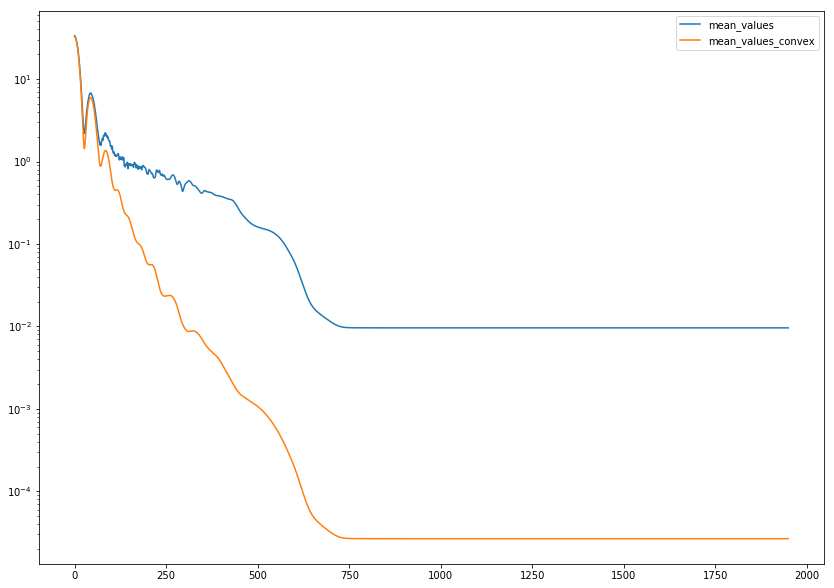

In [73]:
df.plot(
    y=['mean_values', 'mean_values_convex'],
    logy=True,
)
plt.tight_layout()
plt.show()

After ~750 nothing seems to be happening. Look at the "interesting" part.

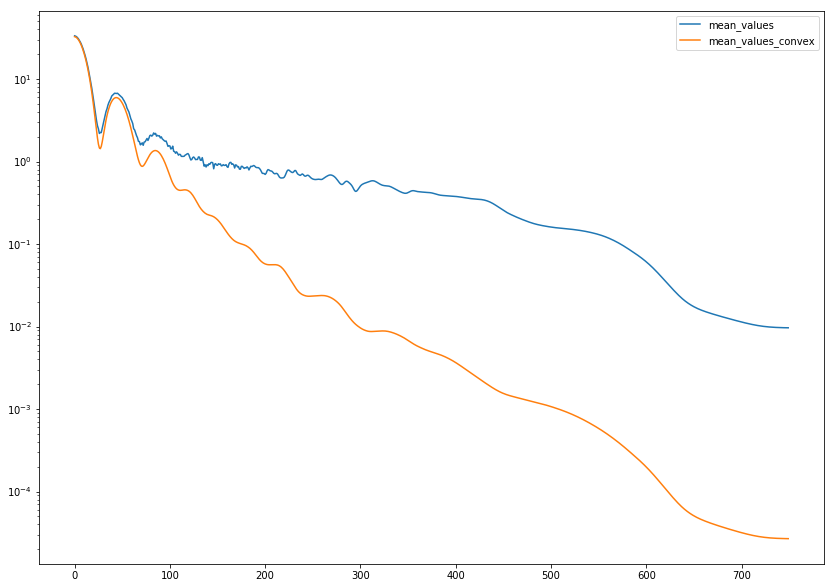

In [74]:
max_iter = 750
df.iloc[:max_iter].plot(
    y=['mean_values', 'mean_values_convex'],
    logy=True,
)
plt.tight_layout()
plt.show()

## Ordinary Least Squares
We want to see if there is a clear exponential evolution of the mean values, so we perform a linear regression.

In [81]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [82]:
df['iteration'] = df.index
model = smf.ols('np.log(mean_values_convex) ~ iteration', data=df.iloc[:max_iter]).fit()

print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     np.log(mean_values_convex)   R-squared:                       0.976
Model:                                    OLS   Adj. R-squared:                  0.976
Method:                         Least Squares   F-statistic:                 3.037e+04
Date:                        Fri, 24 Aug 2018   Prob (F-statistic):               0.00
Time:                                15:25:51   Log-Likelihood:                -632.16
No. Observations:                         750   AIC:                             1268.
Df Residuals:                             748   BIC:                             1278.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

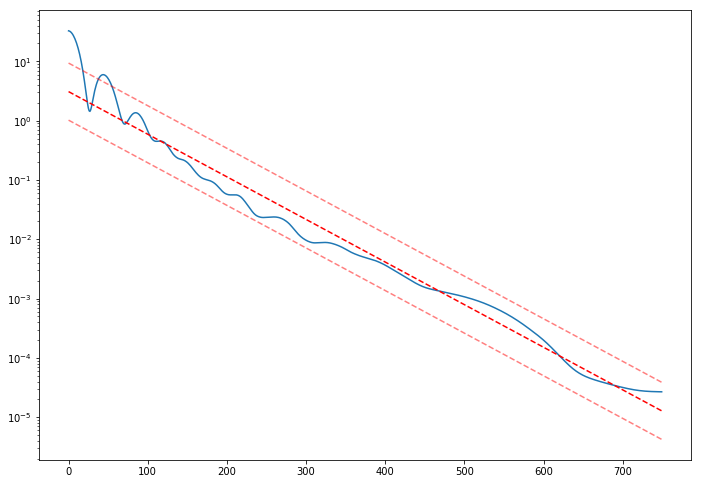

In [85]:
ax = df.mean_values_convex[:max_iter].plot(
    logy=True,
)
prstd, iv_l, iv_u = wls_prediction_std(model)

x = df.index[:max_iter]
ax.plot(x, np.exp(model.fittedvalues), 'r--', label="OLS")
ax.plot(x, np.exp(iv_u), 'r--', alpha=0.5)
ax.plot(x, np.exp(iv_l), 'r--', alpha=0.5)

## Other idea: How does the diff behave?

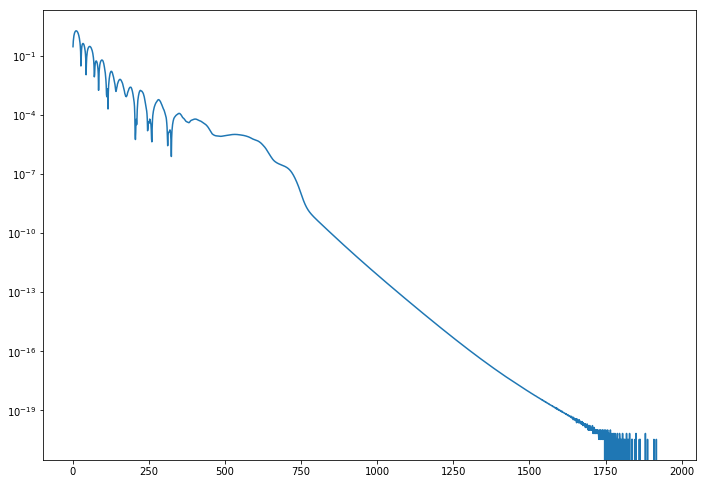

In [15]:
df.mean_values_convex.diff().abs().plot(
    logy=True)

This also looks linear!
Do another linear regression, this time here

In [25]:
df['absolute_change'] = df.mean_values_convex.diff().abs()
diff_model = smf.ols(
    'np.log(absolute_change) ~ iteration',
    data=df[df.absolute_change!=0]
).fit()

print(diff_model.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log(absolute_change)   R-squared:                       0.985
Model:                                 OLS   Adj. R-squared:                  0.985
Method:                      Least Squares   F-statistic:                 1.212e+05
Date:                     Fri, 24 Aug 2018   Prob (F-statistic):               0.00
Time:                             12:06:28   Log-Likelihood:                -3547.9
No. Observations:                     1798   AIC:                             7100.
Df Residuals:                         1796   BIC:                             7111.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

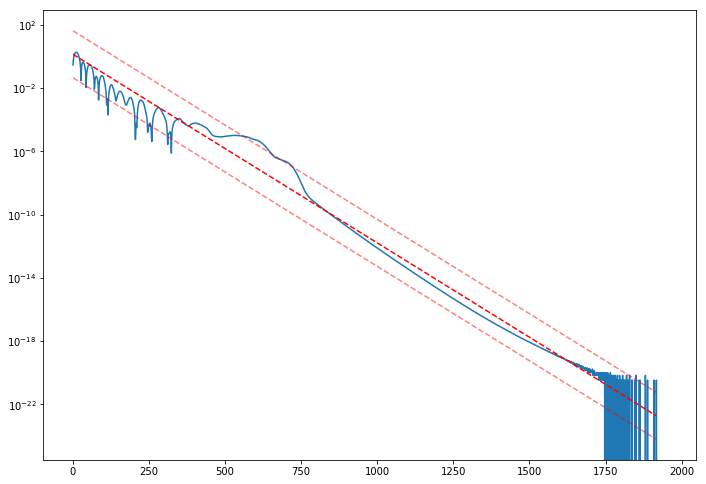

In [38]:
ax = df.absolute_change.plot(
    logy=True,
)
prstd, iv_l, iv_u = wls_prediction_std(diff_model)

x = df.index[df.absolute_change!=0]
ax.plot(diff_model.fittedvalues.index, np.exp(diff_model.fittedvalues), 'r--', label="OLS")
ax.plot(iv_u.index, np.exp(iv_u), 'r--', alpha=0.5)
ax.plot(iv_l.index, np.exp(iv_l), 'r--', alpha=0.5)